In [1]:
from standardInclude import *

Welcome to JupyROOT 6.12/06
For interactive plots, run: setint()
To return to non-interactive plots (default state), run: noint()


### This notebook seeks to recreate the algorithm used in calculateDeltaTConstants.C from Jason in python, hopefully in a way that is a little more readable.

We will use the method detailed in note 16841 to construct a matrix of deltaT clusters for adjacent crystals in each calorimeter, and then use SciPy singular value decomposition in order to arrive at the xtal-to-xtal timing alignment constants for each calorimeter.

Matrix = 1/-1 depending on the calorimeters being subtracted
RHS = vector of deltaT values (mean from gaussian fit)

Both of these should be divided by the sigma from the gaussian fit

---

In [2]:
f = r.TFile("./data/gm2deltaTAnalysis_full.root")
f.cd("neighboringCrystalsDeltaT")
f.ls()

TFile**		./data/gm2deltaTAnalysis_full.root	
 TFile*		./data/gm2deltaTAnalysis_full.root	
  TDirectoryFile*		neighboringCrystalsDeltaT	neighboringCrystalsDeltaT (NeighboringCrystalsTimeExtraction) folder
   KEY: TH3D	hitDeltaT0;1	calo 0 delta t
   KEY: TH3D	hitDeltaT1;1	calo 1 delta t
   KEY: TH3D	hitDeltaT2;1	calo 2 delta t
   KEY: TH3D	hitDeltaT3;1	calo 3 delta t
   KEY: TH3D	hitDeltaT4;1	calo 4 delta t
   KEY: TH3D	hitDeltaT5;1	calo 5 delta t
   KEY: TH3D	hitDeltaT6;1	calo 6 delta t
   KEY: TH3D	hitDeltaT7;1	calo 7 delta t
   KEY: TH3D	hitDeltaT8;1	calo 8 delta t
   KEY: TH3D	hitDeltaT9;1	calo 9 delta t
   KEY: TH3D	hitDeltaT10;1	calo 10 delta t
   KEY: TH3D	hitDeltaT11;1	calo 11 delta t
   KEY: TH3D	hitDeltaT12;1	calo 12 delta t
   KEY: TH3D	hitDeltaT13;1	calo 13 delta t
   KEY: TH3D	hitDeltaT14;1	calo 14 delta t
   KEY: TH3D	hitDeltaT15;1	calo 15 delta t
   KEY: TH3D	hitDeltaT16;1	calo 16 delta t
   KEY: TH3D	hitDeltaT17;1	calo 17 delta t
   KEY: TH3D	hitDeltaT18;1	calo 18 delta t

In [3]:
calo = 2
h = f.Get("neighboringCrystalsDeltaT/hitDeltaT"+str(calo)).Clone("h_"+str(calo))
h.SetDirectory(0)

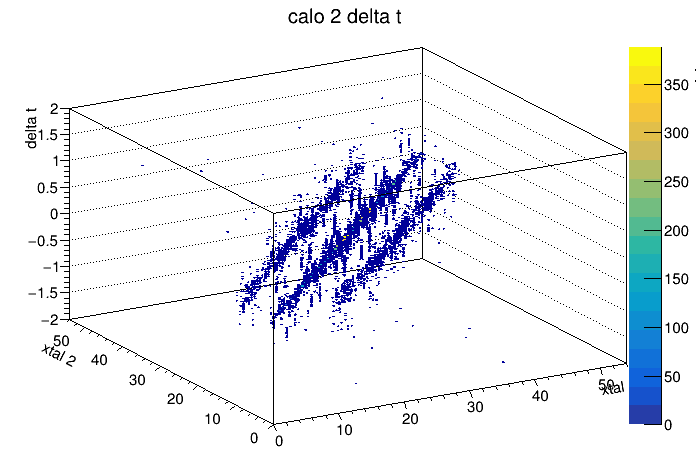

In [4]:
c = r.TCanvas()
h.Draw("lego2z")
c.Draw()

In [5]:
#converts xtal number into x/y position in calorimeter and vice versa
def xtalNumToPosition(x, y = np.nan):
    #if we are given two values, convert xtal position in calo to xtal number
    if(y is not np.nan):
        return x + y*9
    else:
        return (x % 9, int(np.floor(x/9)))

#returns the neighboring crystals in a grid in the form of an iterator
def ReturnNeighbors_NoDiagonal(x, y):
    for i in range(x - 1, x + 2):
        for j in range(y - 1, y + 2):
            if (((i, j) != (x, y)) and i < 9 and j < 6 and i > -1 and j > -1):
                #print(np.abs(i-x) + np.abs(j-y), i, j )
                if(np.abs(i-x) + np.abs(j-y) < 2):
                    yield (int(i), int(j))

In [130]:
#this crystals deltaT value will be set to 0 as a reference
xtalToFix = 0

Starting calo 1
Starting calo 2
Starting calo 3
Starting calo 4
Starting calo 5
Starting calo 6
Starting calo 7
Starting calo 8
Starting calo 9
Starting calo 10
Starting calo 11
Starting calo 12
Starting calo 13
Starting calo 14
Starting calo 15
Starting calo 16
Starting calo 17
Starting calo 18
Starting calo 19
Starting calo 20
Starting calo 21
Starting calo 22
Starting calo 23
Starting calo 24


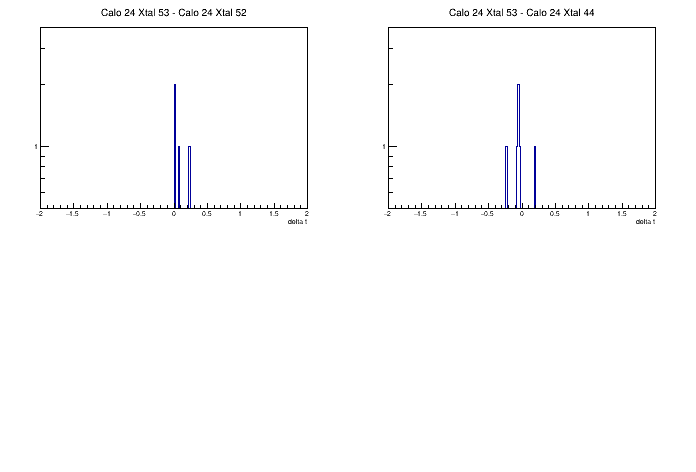

In [131]:
shape = (1,54) #shape of each row in the calorimeter matrix
caloMatrices = []

for calo in range(1,25):
    print("Starting calo", calo)
    
    #get the histogram for this calo
    h = f.Get("neighboringCrystalsDeltaT/hitDeltaT"+str(calo-1)).Clone("h_"+str(calo))
    h.SetDirectory(0)
    
    #create a matrix in which to store the xtal values and the deltaT value
    matrix = np.zeros(shape, dtype=float)
    rhs = np.zeros((1,1),dtype=float)
    #print(matrix)
    #print(rhs)

    takenPairs = [] #use this to avoid processing pairs like (1,0)/(0,1) twice
    for xtal in range(54):
        #print("************************************************")
        #print("Starting Xtal", xtal)
        adjXtals = []
        c = r.TCanvas()
        c.Divide(2,2)
        i = 0
        for x2, y2 in ReturnNeighbors_NoDiagonal(xtalNumToPosition(xtal)[0],xtalNumToPosition(xtal)[1]):
            c.cd(i+1)
            xtal2 = xtalNumToPosition(x2,y2)
            #print(xtal, xtal2)
            
            #get the deltaT histogram for this pair of crystals
            bin_xtal = h.GetXaxis().FindBin(xtal)
            bin_xtal2 = h.GetYaxis().FindBin(xtal2)
            h.GetXaxis().SetRange(bin_xtal, bin_xtal)
            h.GetYaxis().SetRange(bin_xtal2, bin_xtal2)
            hi = h.Project3D("z").Clone("h_"+str(xtal2))
            hi.SetTitle("Calo "+str(calo)+" Xtal "+str(xtal)+" - "+"Calo "+str(calo)+" Xtal "+str(xtal2))
            adjXtals.append(hi.Clone("h_"+str(xtal2)))
            adjXtals[i].Draw()
            i+=1
            r.gPad.SetLogy()

            #calculate the mean and stdev of the deltaT histogram
            mean = hi.GetMean() #later change to values from gaussian fit
            stdev = 1
            #print(mean,stdev)

            #create a new row in each of the matrices and set the values accordingly
            newMatrixRow = [[0 for i in range(54)]]
            if(xtal == xtalToFix):
                newMatrixRow[0][xtal] = +1000000
            else:
                newMatrixRow[0][xtal] = +1/stdev
            newMatrixRow[0][xtal2] = -1/stdev
            newRHS = [[mean/stdev]]
            #print(newMatrixRow)

            #append these rows to the existing matrices and update the pairs which have been processed
            if( (xtal, xtal2) not in takenPairs and (xtal2, xtal) not in takenPairs ):
                matrix = np.append(matrix, newMatrixRow, 0)
                rhs = np.append(rhs, newRHS, 0)
                takenPairs.append((xtal,xtal2))

        #hi.Draw()
        c.Draw()
        #print(takenPairs)
        #print([xtalNumToPosition(t[0], t[1]) for t in takenPairs])

    #delete first placeholder row
    matrix = np.delete(matrix, 0, 0)
    rhs = np.delete(rhs, 0, 0)
    
    #add to running list of all calos
    caloMatrices.append((calo, matrix, rhs))

In [132]:
#now lets do the SVD using numpy
#    see: https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.svd.html
caloSVD = []

for calo, matrix, rhs in caloMatrices:
    timeConstants, residuals, rankOfMatrix, singularValuesOfMatrix  = np.linalg.lstsq(matrix, rhs)
    caloSVD.append( (calo, timeConstants, residuals, rankOfMatrix, singularValuesOfMatrix) )

/home/jlab/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


In [133]:
print([x[0] for x in caloSVD])

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]


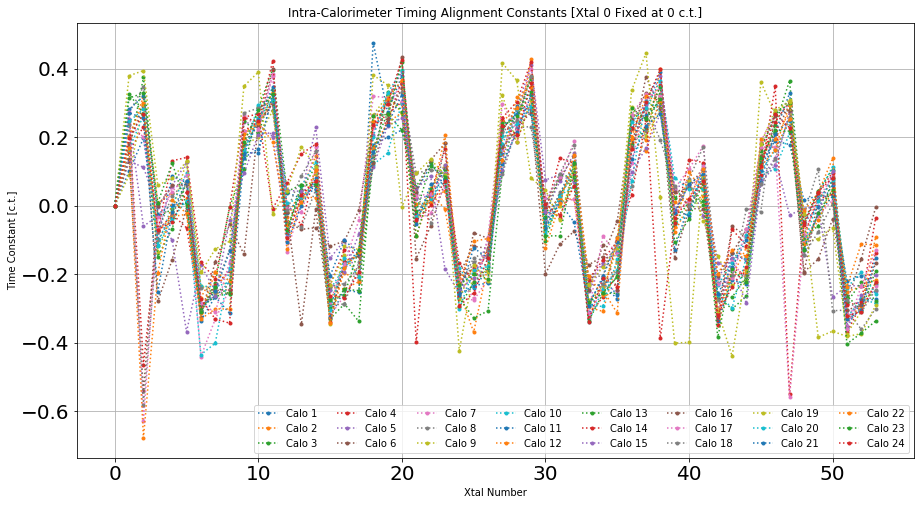

In [134]:
fig, ax = plt.subplots(figsize=(15,8))
#plt.ylim(-0.3,0.6)
for calo in range(24):
    plt.plot([i for i in range(54)], caloSVD[calo][1], ".:", label="Calo "+str(calo+1))
plt.legend(ncol=8)
plt.title("Intra-Calorimeter Timing Alignment Constants [Xtal "+str(xtalToFix)+" Fixed at 0 c.t.]")
plt.xlabel("Xtal Number")
plt.ylabel("Time Constant [c.t.]")
plt.grid()
plt.show()

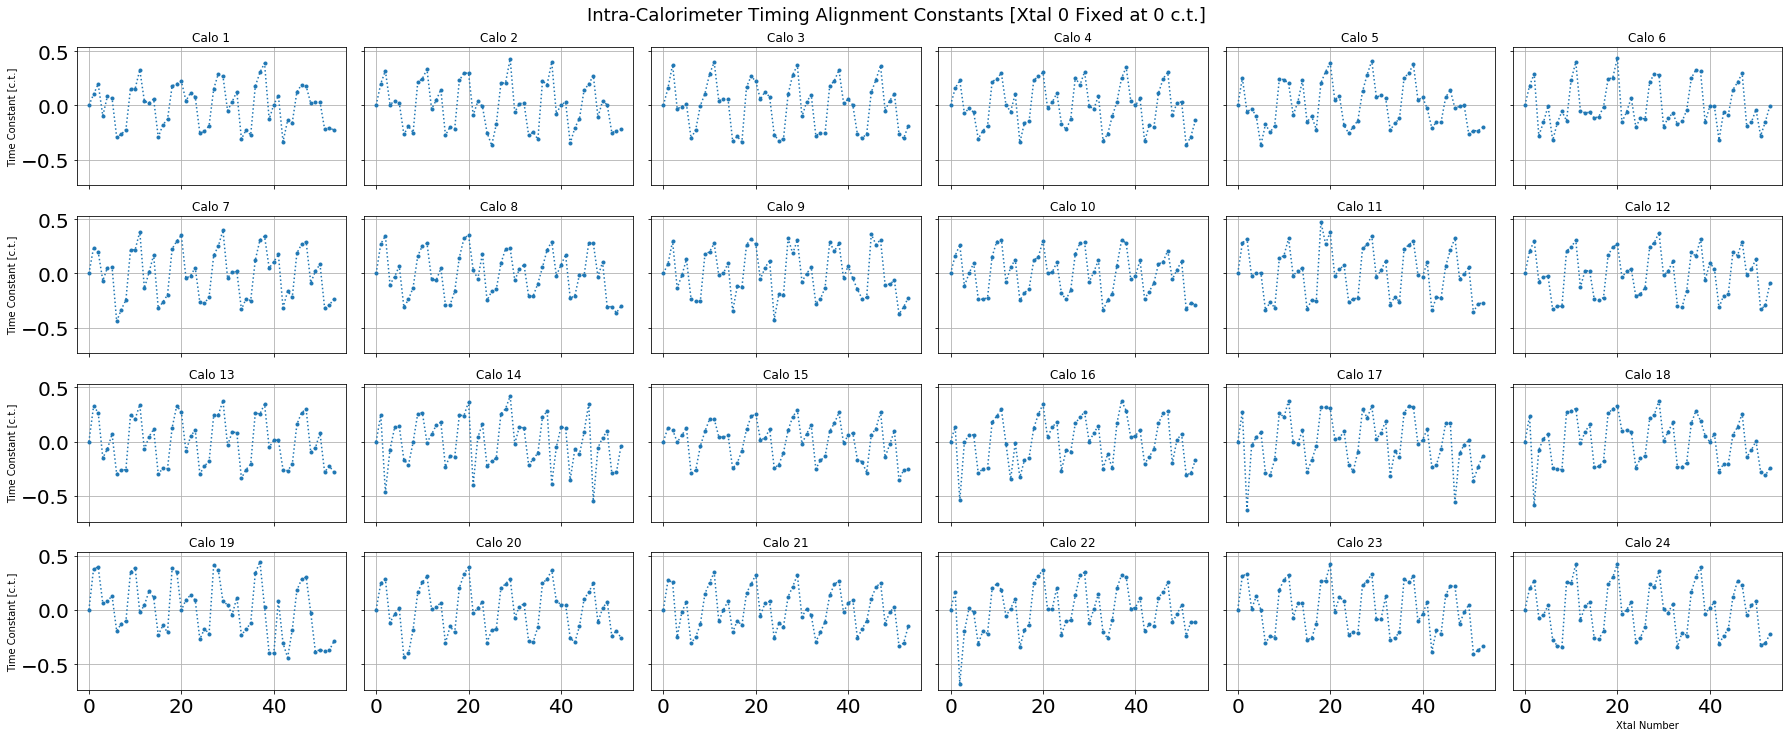

In [124]:
fig, axs = plt.subplots(4,6,figsize=(25,10), sharex=True, sharey=True)
#plt.ylim(-0.3,0.6)
ax = flatten2dArray(axs)
for calo in range(24):
    ax[calo].plot([i for i in range(54)], caloSVD[calo][1], ".:", label="Calo "+str(calo+1))
    ax[calo].set_title("Calo "+str(calo+1))
    ax[calo].grid()
    if(calo % 6 == 0):
        ax[calo].set_ylabel("Time Constant [c.t.]")
#plt.legend(ncol=8)
plt.suptitle("Intra-Calorimeter Timing Alignment Constants [Xtal "+str(xtalToFix)+" Fixed at 0 c.t.]",y=1.02, fontsize=18)
plt.xlabel("Xtal Number")
plt.tight_layout()
plt.show()